In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/malayakew-plant-leaf-dataset/MK/readMe.txt
/kaggle/input/malayakew-plant-leaf-dataset/MK/name_of_spesies.txt
/kaggle/input/malayakew-plant-leaf-dataset/MK/D2/test_patch/Class26/Class26(8)R225_00163.jpg
/kaggle/input/malayakew-plant-leaf-dataset/MK/D2/test_patch/Class26/Class26(7)R45_00145.jpg
/kaggle/input/malayakew-plant-leaf-dataset/MK/D2/test_patch/Class26/Class26(6)R90_00108.jpg
/kaggle/input/malayakew-plant-leaf-dataset/MK/D2/test_patch/Class26/Class26(5)R225_00097.jpg
/kaggle/input/malayakew-plant-leaf-dataset/MK/D2/test_patch/Class26/Class26(8)R315_00162.jpg
/kaggle/input/malayakew-plant-leaf-dataset/MK/D2/test_patch/Class26/Class26(4)R180_00074.jpg
/kaggle/input/malayakew-plant-leaf-dataset/MK/D2/test_patch/Class26/Class26(7)R180_00141.jpg
/kaggle/input/malayakew-plant-leaf-dataset/MK/D2/test_patch/Class26/Class26(3)R225_00050.jpg
/kaggle/input/malayakew-plant-leaf-dataset/MK/D2/test_patch/Class26/Class26(7)R0_00145.jpg
/kaggle/input/malayakew-plant-leaf-dataset/M

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import cv2 as cv
from tqdm.notebook import tqdm_notebook as tqdm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential,Model
from keras.applications import vgg16,vgg19,resnet
from keras.preprocessing.image import ImageDataGenerator


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Import Images

In [3]:
import os
import numpy as np
from PIL import Image

def read_images_from_folders(root_folder, folder_names):
    images = []
    labels = []
    label_num = 0
    image_width=128
    image_height=128
    
    for folder in sorted(os.listdir(root_folder)):
        if folder in folder_names:
            folder_path = os.path.join(root_folder, folder)
            if os.path.isdir(folder_path):
                for filename in os.listdir(folder_path):
                    img_path = os.path.join(folder_path, filename)
                    try:
                        img = Image.open(img_path)
                        img = img.resize((image_width, image_height))  # Resize images if necessary
                        img_array = np.array(img)
                        images.append(img_array)
                        labels.append(label_num)
                    except Exception as e:
                        print(f"Error reading image: {img_path} - {e}")
                label_num += 1
    
    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels


In [4]:
# Example usage:
root_folder = '/kaggle/input/malayakew-plant-leaf-dataset/MK/D1/train'
selected_folders = ['Class (26)', 'Class (27)']  # Replace with the folder names you want to read
X_train, y_train = read_images_from_folders(root_folder, selected_folders)
root_folder = '/kaggle/input/malayakew-plant-leaf-dataset/MK/D1/test'
X_test, y_test = read_images_from_folders(root_folder, selected_folders)


In [5]:
print("Images shape:", X_train.shape)
print("Labels shape:", y_train.shape)
print("Images shape:", X_test.shape)
print("Labels shape:", y_test.shape)

Images shape: (104, 128, 128, 3)
Labels shape: (104,)
Images shape: (24, 128, 128, 3)
Labels shape: (24,)


In [6]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator with desired augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to apply augmentation twice to each dataset
def augment_dataset(dataset):
    augmented_data = []
    for img in dataset:
        img = np.expand_dims(img, axis=0)  # Expanding dimensions for batch size
        for _ in range(3):  # Apply augmentation twice
            seed = np.random.randint(0, 1000)  # Different seed for each pass
            for batch in datagen.flow(img, batch_size=1, seed=seed):
                augmented_data.append(np.squeeze(batch))  # Remove the batch dimension
                break  # Stop the loop after one augmented image
    return np.array(augmented_data)

# Apply augmentation twice to X_train, X_test, and X_val
X_train_augmented = augment_dataset(X_train)
y_train_augmented = np.repeat(y_train, 3, axis=0)  # Adjust based on augmentation factor


# Check the shapes of augmented datasets
print("X_train_augmented shape:", X_train_augmented.shape)
print("y_train_augmented shape:", y_train_augmented.shape)


X_train_augmented shape: (312, 128, 128, 3)
y_train_augmented shape: (312,)


In [8]:
from sklearn.utils import shuffle

# Combine original data with augmented data
X_train_combined = np.concatenate((X_train, X_train_augmented))
y_train_combined = np.concatenate((y_train, y_train_augmented))


X_train_combined, y_train_combined = shuffle(X_train_combined, y_train_combined, random_state=42)


In [9]:
print("X_train_combined shape:", X_train_combined.shape)


X_train_combined shape: (416, 128, 128, 3)


# Model Vgg16

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
import kerastuner as kt

def build_model(hp):
    vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    
    # Freeze all layers except the last 4 convolutional blocks
#     for layer in vgg_base.layers:
#         layer.trainable = True
    for layer in vgg_base.layers:
        layer.trainable = True
    
    model = models.Sequential()
    model.add(vgg_base)
    model.add(layers.Flatten())
    
    # Tune FC layer units and dropout rate
    model.add(layers.Dense(units=hp.Int('units', min_value=64, max_value=1024, step=32), activation='relu'))
    model.add(layers.Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.9, step=0.1)))
    model.add(layers.Dense(units=hp.Int('units', min_value=64, max_value=1024, step=32), activation='relu'))
    model.add(layers.Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.9, step=0.1)))
    model.add(layers.Dense(units=hp.Int('units', min_value=64, max_value=1024, step=32), activation='relu'))
    model.add(layers.Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.9, step=0.1)))
 
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
#     optimizer = hp.Choice(name='optimizer',values=['rmsprop','adam','adagrad','sgd','adadelta'])
    metrics = [
        'accuracy',
        tf.keras.metrics.AUC(),
#         tf.keras.metrics.Accuracy(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.SpecificityAtSensitivity(0.5),
        tf.keras.metrics.SensitivityAtSpecificity(0.5),
        tf.keras.metrics.FalseNegatives(),
        tf.keras.metrics.FalsePositives(),
        tf.keras.metrics.TrueNegatives(),
        tf.keras.metrics.TruePositives(),
        tf.keras.metrics.F1Score()
    ]
    model.compile(
        optimizer = 'adam',
#         loss =  "sparse_categorical_crossentropy",
        loss='binary_crossentropy',
        metrics=metrics
        
    )
    
    return model


# Model Resnet

In [36]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
import kerastuner as kt

def build_model(hp):
    res_base = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    
    # Freeze all layers except the last 4 convolutional blocks
    for layer in res_base.layers:
        layer.trainable = True
#     res_base.trainable= True
    
    model = models.Sequential()
    model.add(res_base)
    model.add(layers.Flatten())
    
     # Tune FC layer units and dropout rate
    model.add(layers.Dense(units=hp.Int('units', min_value=64, max_value=1024, step=32), activation='relu'))
    model.add(layers.Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.9, step=0.1)))
    model.add(layers.Dense(units=hp.Int('units', min_value=64, max_value=1024, step=32), activation='relu'))
    model.add(layers.Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.9, step=0.1)))
    model.add(layers.Dense(units=hp.Int('units', min_value=64, max_value=1024, step=32), activation='relu'))
    model.add(layers.Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.9, step=0.1)))
 
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
#     optimizer = hp.Choice(name='optimizer',values=['rmsprop','adam','adagrad','sgd','adadelta'])
    metrics = [
        'accuracy',
        tf.keras.metrics.AUC(),
#         tf.keras.metrics.Accuracy(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.SpecificityAtSensitivity(0.5),
        tf.keras.metrics.SensitivityAtSpecificity(0.5),
        tf.keras.metrics.FalseNegatives(),
        tf.keras.metrics.FalsePositives(),
        tf.keras.metrics.TrueNegatives(),
        tf.keras.metrics.TruePositives(),
        tf.keras.metrics.F1Score()

    ]
    model.compile(
        optimizer = 'adam',
#         loss =  "sparse_categorical_crossentropy",
        loss='binary_crossentropy',
        metrics=metrics
        
    )
    
    return model


# Model Vgg19

In [89]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG19
import kerastuner as kt

def build_model(hp):
    google_base = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    
    # Freeze all layers except the last 4 convolutional blocks
    for layer in google_base.layers:
        layer.trainable = False
#     res_base.trainable= True
    
    model = models.Sequential()
    model.add(google_base)
    model.add(layers.Flatten())
    
     # Tune FC layer units and dropout rate
    model.add(layers.Dense(units=hp.Int('units', min_value=64, max_value=1024, step=32), activation='relu'))
    model.add(layers.Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.9, step=0.1)))
    model.add(layers.Dense(units=hp.Int('units', min_value=64, max_value=1024, step=32), activation='relu'))
    model.add(layers.Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.9, step=0.1)))
    model.add(layers.Dense(units=hp.Int('units', min_value=64, max_value=1024, step=32), activation='relu'))
    model.add(layers.Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.9, step=0.1)))
 
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
#     optimizer = hp.Choice(name='optimizer',values=['rmsprop','adam','adagrad','sgd','adadelta'])
    metrics = [
        'accuracy',
        tf.keras.metrics.AUC(),
#         tf.keras.metrics.Accuracy(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.SpecificityAtSensitivity(0.5),
        tf.keras.metrics.SensitivityAtSpecificity(0.5),
        tf.keras.metrics.FalseNegatives(),
        tf.keras.metrics.FalsePositives(),
        tf.keras.metrics.TrueNegatives(),
        tf.keras.metrics.TruePositives(),
        tf.keras.metrics.F1Score()

    ]
    model.compile(
        optimizer = 'adam',
#         loss =  "sparse_categorical_crossentropy",
        loss='binary_crossentropy',
        metrics=metrics
        
    )
    
    return model


# Xception Model

In [76]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.applications import Xception
import kerastuner as kt

def build_model(hp):
    google_base = Xception(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    
    # Freeze all layers except the last 4 convolutional blocks
    for layer in google_base.layers:
        layer.trainable = False
#     res_base.trainable= True
    
    model = models.Sequential()
    model.add(google_base)
    model.add(layers.Flatten())
    
     # Tune FC layer units and dropout rate
    model.add(layers.Dense(units=hp.Int('units', min_value=64, max_value=1024, step=32), activation='relu'))
    model.add(layers.Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.9, step=0.1)))
    model.add(layers.Dense(units=hp.Int('units', min_value=64, max_value=1024, step=32), activation='relu'))
    model.add(layers.Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.9, step=0.1)))
    model.add(layers.Dense(units=hp.Int('units', min_value=64, max_value=1024, step=32), activation='relu'))
    model.add(layers.Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.9, step=0.1)))
 
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
#     optimizer = hp.Choice(name='optimizer',values=['rmsprop','adam','adagrad','sgd','adadelta'])
    metrics = [
        'accuracy',
        tf.keras.metrics.AUC(),
#         tf.keras.metrics.Accuracy(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.SpecificityAtSensitivity(0.5),
        tf.keras.metrics.SensitivityAtSpecificity(0.5),
        tf.keras.metrics.FalseNegatives(),
        tf.keras.metrics.FalsePositives(),
        tf.keras.metrics.TrueNegatives(),
        tf.keras.metrics.TruePositives(),
        tf.keras.metrics.F1Score()

    ]
    model.compile(
        optimizer = 'adam',
#         loss =  "sparse_categorical_crossentropy",
        loss='binary_crossentropy',
        metrics=metrics
        
    )
    
    return model


# Hyper Parameters tuning

In [90]:
from tensorflow import keras
from tensorflow.keras import layers
import kerastuner as kt

objective = kt.Objective(
name="val_accuracy",
direction="max")

tuner = kt.GridSearch(
    build_model,
    objective=objective,
    max_trials = 20,
    executions_per_trial=5,
    directory="mnist_kt_test",
    overwrite=True,
)

tuner.search_space_summary()
tuner.search(X_train_combined, y_train_combined.astype('float32'), epochs=5,validation_split=0.2)


Trial 20 Complete [00h 00m 46s]
val_accuracy: 0.8071428537368774

Best val_accuracy So Far: 0.9928571343421936
Total elapsed time: 00h 16m 28s


In [91]:
best_hp = tuner.get_best_hyperparameters()[0]
print(best_hp)
best_model = tuner.hypermodel.build(best_hp)

In [92]:
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 128)              

In [93]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('plants_vgg19_not-fined.h5',save_best_only=True),
    tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',patience=3
    )
]
history = best_model.fit(X_train_combined, y_train_combined.astype('float32'), epochs=50,batch_size=32,validation_split=0.2,callbacks=callbacks)

Epoch 1/50
11/11 [==============================] - 4s 168ms/step - loss: 0.6905 - accuracy: 0.5783 - auc_1: 0.6451 - recall_1: 0.5793 - precision_1: 0.5723 - specificity_at_sensitivity_1: 0.6607 - sensitivity_at_specificity_1: 0.6768 - false_negatives_1: 69.0000 - false_positives_1: 71.0000 - true_negatives_1: 97.0000 - true_positives_1: 95.0000 - f1_score: 0.6613 - val_loss: 0.4077 - val_accuracy: 0.7976 - val_auc_1: 0.9983 - val_recall_1: 0.6136 - val_precision_1: 1.0000 - val_specificity_at_sensitivity_1: 1.0000 - val_sensitivity_at_specificity_1: 1.0000 - val_false_negatives_1: 17.0000 - val_false_positives_1: 0.0000e+00 - val_true_negatives_1: 40.0000 - val_true_positives_1: 27.0000 - val_f1_score: 0.6875
Epoch 2/50


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 1s 92ms/step - loss: 0.2981 - accuracy: 0.8946 - auc_1: 0.9532 - recall_1: 0.8902 - precision_1: 0.8957 - specificity_at_sensitivity_1: 0.9940 - sensitivity_at_specificity_1: 0.9939 - false_negatives_1: 18.0000 - false_positives_1: 17.0000 - true_negatives_1: 151.0000 - true_positives_1: 146.0000 - f1_score: 0.6613 - val_loss: 0.1758 - val_accuracy: 0.8929 - val_auc_1: 0.9989 - val_recall_1: 0.7955 - val_precision_1: 1.0000 - val_specificity_at_sensitivity_1: 1.0000 - val_sensitivity_at_specificity_1: 1.0000 - val_false_negatives_1: 9.0000 - val_false_positives_1: 0.0000e+00 - val_true_negatives_1: 40.0000 - val_true_positives_1: 35.0000 - val_f1_score: 0.6875
Epoch 3/50
11/11 [==============================] - 1s 91ms/step - loss: 0.2128 - accuracy: 0.9096 - auc_1: 0.9727 - recall_1: 0.8902 - precision_1: 0.9241 - specificity_at_sensitivity_1: 0.9940 - sensitivity_at_specificity_1: 1.0000 - false_negatives_1: 18.0000 - false_positives_1: 12.000

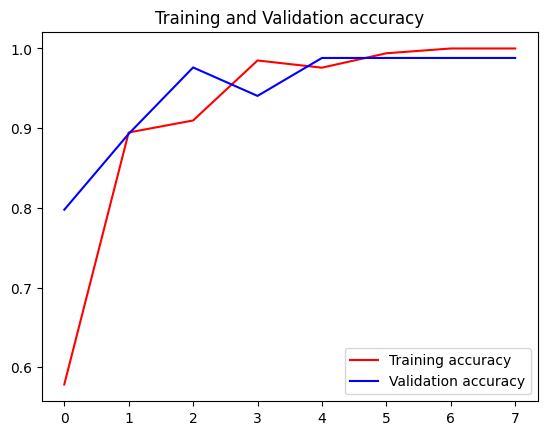

<Figure size 640x480 with 0 Axes>

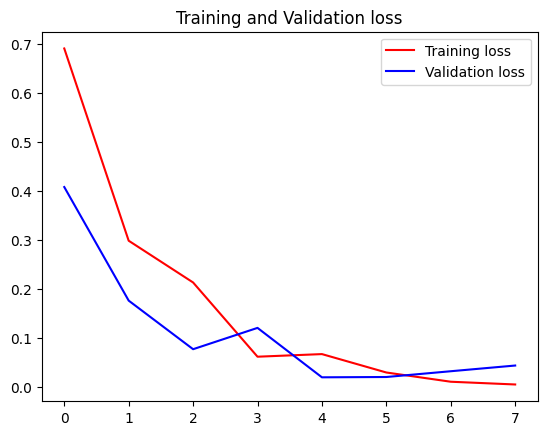

<Figure size 640x480 with 0 Axes>

In [94]:
acc = history.history['accuracy']
val_acc= history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs,acc,'r',label="Training accuracy")
plt.plot(epochs,val_acc,'b',label="Validation accuracy")
plt.title('Training and Validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs,loss,'r',label="Training loss")
plt.plot(epochs,val_loss,'b',label="Validation loss")
plt.title('Training and Validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [96]:
best_model.evaluate(X_test,y_test.astype('float32'))

1/1 [==============================] - 0s 115ms/step - loss: 0.7133 - accuracy: 0.7917 - auc_1: 1.0000 - recall_1: 0.5833 - precision_1: 1.0000 - specificity_at_sensitivity_1: 1.0000 - sensitivity_at_specificity_1: 1.0000 - false_negatives_1: 5.0000 - false_positives_1: 0.0000e+00 - true_negatives_1: 12.0000 - true_positives_1: 7.0000 - f1_score: 0.6667


[0.7132884860038757,
 0.7916666865348816,
 1.0,
 0.5833333134651184,
 1.0,
 1.0,
 1.0,
 5.0,
 0.0,
 12.0,
 7.0,
 array([0.6666667], dtype=float32)]

In [97]:
from sklearn.metrics import classification_report

y_pred = best_model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool =[]
for data in y_pred:
    print(data[0])
    if data[0] < 0.5:
        y_pred_bool.append(0)
    elif data[0] >= 0.5:
        y_pred_bool.append(1)

print(classification_report(y_test, y_pred_bool))

1/1 [==============================] - 0s 205ms/step
1.5597816e-05
0.000786028
2.6592064e-05
2.1502308e-05
9.209635e-06
6.646448e-05
9.439616e-05
0.00044924265
9.635158e-06
0.00018914646
0.00045534738
0.00022498023
0.9999938
0.006057993
0.059159666
0.99999666
0.9996809
0.007973841
0.05791395
0.99997663
0.9993924
0.99569917
0.9998541
0.2238271
              precision    recall  f1-score   support

           0       0.71      1.00      0.83        12
           1       1.00      0.58      0.74        12

    accuracy                           0.79        24
   macro avg       0.85      0.79      0.78        24
weighted avg       0.85      0.79      0.78        24



In [99]:
from sklearn.metrics import f1_score

# Assuming y_true contains the true labels and y_pred contains the predicted labels
f1 = f1_score(y_test, y_pred_bool, average='binary')  # For binary classification
print(f"F1 score: {f1}")


F1 score: 0.7368421052631579


# Draw ROC Curve

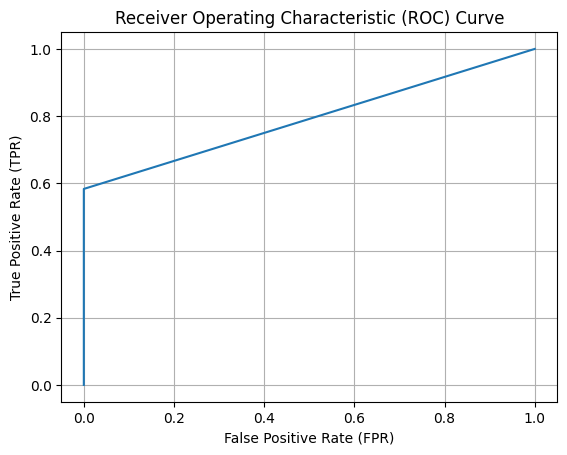

In [100]:
from sklearn.metrics import roc_curve, RocCurveDisplay

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_bool)

# Plot ROC curve
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.grid(True)
plt.show()

# Ensmebling

### Sum Ensemble

In [28]:
from keras.models import load_model
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
from sklearn.metrics import precision_score, recall_score


# Load the models
vgg16M = load_model('/kaggle/input/models/plants_vgg16_notfined.h5',compile=False)
vgg19M = load_model('/kaggle/input/models/plants_vgg19_not-fined.h5',compile=False)
xceptionM = load_model('/kaggle/input/models/plants_xception_not-fined.h5',compile=False)

# Make predictions using the models
pred1 = vgg16M.predict(X_test)
pred2 = vgg19M.predict(X_test)
pred3 = xceptionM.predict(X_test)

# Perform sum ensembling
ensemble_pred = np.sum([pred1, pred2, pred3], axis=0)

# Convert the ensemble predictions to binary values
ensemble_pred_binary = np.where(ensemble_pred >= 0.5, 1, 0)

# Calculate accuracy and F1 score for each model
accuracy1 = accuracy_score(y_test, np.where(pred1 >= 0.5, 1, 0))
accuracy2 = accuracy_score(y_test, np.where(pred2 >= 0.5, 1, 0))
accuracy3 = accuracy_score(y_test, np.where(pred3 >= 0.5, 1, 0))
ensemble_accuracy = accuracy_score(y_test, ensemble_pred_binary)

f1score1 = f1_score(y_test, np.where(pred1 >= 0.5, 1, 0))
f1score2 = f1_score(y_test, np.where(pred2 >= 0.5, 1, 0))
f1score3 = f1_score(y_test, np.where(pred3 >= 0.5, 1, 0))
ensemble_f1score = f1_score(y_test, ensemble_pred_binary)


# Calculate precision for individual models
precision1 = precision_score(y_test, np.where(pred1 >= 0.5, 1, 0))
precision2 = precision_score(y_test, np.where(pred2 >= 0.5, 1, 0))
precision3 = precision_score(y_test, np.where(pred3 >= 0.5, 1, 0))

# Calculate precision for ensemble predictions
ensemble_precision = precision_score(y_test, ensemble_pred_binary)

# Calculate recall for individual models
recall1 = recall_score(y_test, np.where(pred1 >= 0.5, 1, 0))
recall2 = recall_score(y_test, np.where(pred2 >= 0.5, 1, 0))
recall3 = recall_score(y_test, np.where(pred3 >= 0.5, 1, 0))

# Calculate recall for ensemble predictions
ensemble_recall = recall_score(y_test, ensemble_pred_binary)



# Print the accuracy and F1 score for each model and the ensemble
print("Model 1 Accuracy:", accuracy1)
print("Model 2 Accuracy:", accuracy2)
print("Model 3 Accuracy:", accuracy3)
print("Ensemble Accuracy:", ensemble_accuracy)

print("Model 1 F1 Score:", f1score1)
print("Model 2 F1 Score:", f1score2)
print("Model 3 F1 Score:", f1score3)
print("Ensemble F1 Score:", ensemble_f1score)

# Print precision scores
print("Precision for Model 1:", precision1)
print("Precision for Model 2:", precision2)
print("Precision for Model 3:", precision3)
print("Ensemble Precision:", ensemble_precision)

# Print recall scores
print("Recall for Model 1:", recall1)
print("Recall for Model 2:", recall2)
print("Recall for Model 3:", recall3)
print("Ensemble Recall:", ensemble_recall)



1/1 [==============================] - 1s 857ms/step
Model 1 Accuracy: 0.8333333333333334
Model 2 Accuracy: 0.9166666666666666
Model 3 Accuracy: 0.9583333333333334
Ensemble Accuracy: 0.9583333333333334
Model 1 F1 Score: 0.8
Model 2 F1 Score: 0.9090909090909091
Model 3 F1 Score: 0.9565217391304348
Ensemble F1 Score: 0.9565217391304348
Precision for Model 1: 1.0
Precision for Model 2: 1.0
Precision for Model 3: 1.0
Ensemble Precision: 1.0
Recall for Model 1: 0.6666666666666666
Recall for Model 2: 0.8333333333333334
Recall for Model 3: 0.9166666666666666
Ensemble Recall: 0.9166666666666666


### Search for weights for ensembling

In [29]:
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import numpy as np

# Assuming you have predictions from three models: preds_model1, preds_model2, preds_model3
# Combine these predictions into a list
predictions = [vgg16M.predict(X_test), vgg19M.predict(X_test), xceptionM.predict(X_test)]
predictions = np.array(predictions)

# Generate different weight combinations and find the best weights
df = pd.DataFrame([])

for w1 in range(0, 11):
    for w2 in range(0, 11):
        for w3 in range(0, 11):
            if w1 + w2 + w3 == 10:  # Ensuring weights sum up to 1
                weights = [w1 / 10., w2 / 10., w3 / 10.]
                weighted_predictions = np.tensordot(predictions, weights, axes=((0), (0)))
                ensemble_prediction = np.round(weighted_predictions.mean(axis=1))  # Rounded for binary classification

                acc = accuracy_score(y_test, ensemble_prediction)
                f1 = f1_score(y_test, ensemble_prediction)
                precision = precision_score(y_test, ensemble_prediction)
                recall = recall_score(y_test, ensemble_prediction)

                df = pd.concat([df, pd.DataFrame({'wt1': weights[0], 'wt2': weights[1], 'wt3': weights[2], 'acc': acc, 'f1': f1, 'precision': precision, 'recall': recall}, index=[0])], ignore_index=True)

# Retrieve best weights based on accuracy, F1 score, precision, and recall
best_accuracy_row = df.iloc[df['acc'].idxmax()]
best_f1_row = df.iloc[df['f1'].idxmax()]
best_precision_row = df.iloc[df['precision'].idxmax()]
best_recall_row = df.iloc[df['recall'].idxmax()]

print("Best accuracy:", best_accuracy_row['acc'], "with weights:", best_accuracy_row[['wt1', 'wt2', 'wt3']])
print("Best F1 score:", best_f1_row['f1'], "with weights:", best_f1_row[['wt1', 'wt2', 'wt3']])
print("Best Precision:", best_precision_row['precision'], "with weights:", best_precision_row[['wt1', 'wt2', 'wt3']])
print("Best Recall:", best_recall_row['recall'], "with weights:", best_recall_row[['wt1', 'wt2', 'wt3']])


1/1 [==============================] - 0s 26ms/step
Best accuracy: 0.9583333333333334 with weights: wt1    0.0
wt2    0.0
wt3    1.0
Name: 0, dtype: float64
Best F1 score: 0.9565217391304348 with weights: wt1    0.0
wt2    0.0
wt3    1.0
Name: 0, dtype: float64
Best Precision: 1.0 with weights: wt1    0.0
wt2    0.0
wt3    1.0
Name: 0, dtype: float64
Best Recall: 0.9166666666666666 with weights: wt1    0.0
wt2    0.0
wt3    1.0
Name: 0, dtype: float64


### Average Weighted Ensemble

In [30]:
from keras.models import load_model
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# Make predictions using the models
pred1 = vgg16M.predict(X_test)
pred2 = vgg19M.predict(X_test)
pred3 = xceptionM.predict(X_test)
# Define the weights for each model
weights = [0.0, 0.0, 1.0]

# Perform weighted average ensembling
ensemble_pred = (pred1 * weights[0]) + (pred2 * weights[1]) + (pred3 * weights[2])

# Convert the ensemble predictions to binary values
ensemble_pred_binary = np.where(ensemble_pred >= 0.5, 1, 0)

# Calculate accuracy, F1 score, precision, and recall for the ensemble
ensemble_accuracy = accuracy_score(y_test, ensemble_pred_binary)
ensemble_f1score = f1_score(y_test, ensemble_pred_binary)
ensemble_precision = precision_score(y_test, ensemble_pred_binary)
ensemble_recall = recall_score(y_test, ensemble_pred_binary)

# Print the metrics for the ensemble
print("Ensemble Accuracy:", ensemble_accuracy)
print("Ensemble F1 Score:", ensemble_f1score)
print("Ensemble Precision:", ensemble_precision)
print("Ensemble Recall:", ensemble_recall)

1/1 [==============================] - 0s 28ms/step
Ensemble Accuracy: 0.9583333333333334
Ensemble F1 Score: 0.9565217391304348
Ensemble Precision: 1.0
Ensemble Recall: 0.9166666666666666


# Visualization

## Confusion Matrix

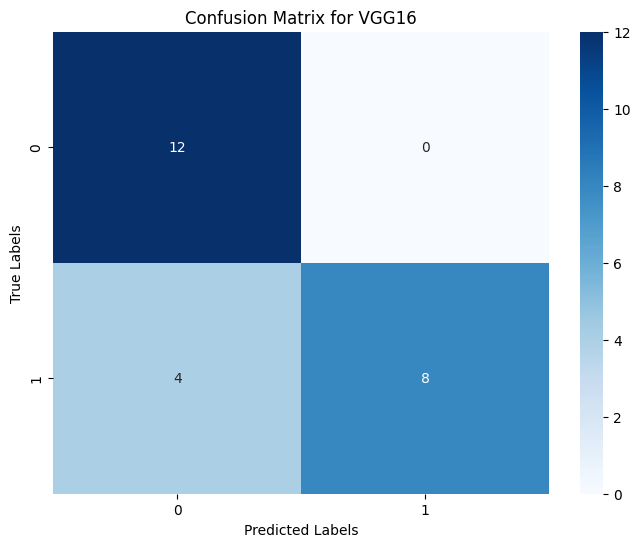

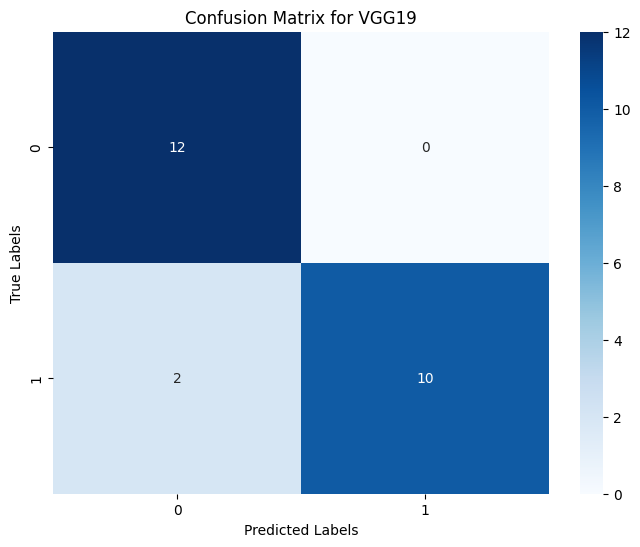

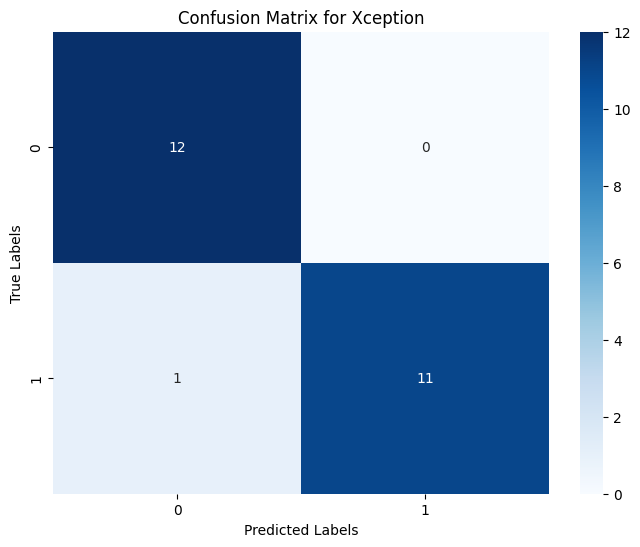

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



# Compute confusion matrix
conf_matrix_vgg16 = confusion_matrix(y_test, np.where(pred1 >= 0.5, 1, 0))
conf_matrix_vgg19 = confusion_matrix(y_test, np.where(pred2 >= 0.5, 1, 0))
conf_matrix_Xception = confusion_matrix(y_test, np.where(pred3 >= 0.5, 1, 0))


# Display confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_vgg16, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for VGG16')

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_vgg19, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for VGG19')

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_Xception, annot=True, cmap='Blues', fmt='g')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Xception')
plt.show()
